<a href="https://colab.research.google.com/github/lesi-nedo/ISPR_assignments/blob/main/Assignment_6_o_nedobiychuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center" ><b> <font face="Rage" size=7 >SIFT Descriptors</font></b></div>

<div align="center" ><b> <font face="Rage" size=5 >Assignment 6</font></b></div>
<div align="center" ><b> <font face="Rage" size=4 >Oleksiy Nedobiychuk</font></b></div>


In [ ]:
from google.colab import drive
import os
import cv2



drive.mount('/content/drive/')
uploaded = {}
path = '/content/drive/My Drive/horse/'
for filename in os.listdir(path):
  uploaded[filename] = cv2.cvtColor(cv2.imread(path + filename), cv2.COLOR_BGR2GRAY)



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


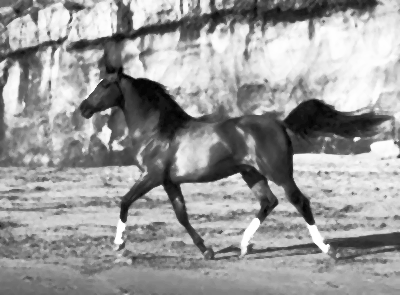

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
import io


all_images_len = len(uploaded)

last = all_images_len - 1

default_shape = (400,295)
all_images = np.empty([all_images_len, default_shape[1], default_shape[0]], dtype=np.uint8)
gamma = 1.5 # The value for the gamma correction
invGamma = 1.0 / gamma

for ind,(filename,image) in enumerate(uploaded.items()):
  resized = cv2.resize(image, default_shape, interpolation=cv2.INTER_LANCZOS4) # all images are resized

  eq_img = cv2.equalizeHist(resized) # to improve contrast, I've done the histogram equalization
  mdb_img = cv2.medianBlur(eq_img, 3) # to reduce noise, I've blured the image
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0,256)]).astype("uint8")
  gcor_img = cv2.LUT(mdb_img, table) #Computes the gamma correction of the image with the table
  all_images[ind] = gcor_img


cv2_imshow(all_images[0])



In the hope of improving SIFT keypoint detection, I applied histogram equalization to the image. Since some of these photos were taken with an old film camera and likely have significant noise, I decided to try applying a blur in the hope of improving the overall outcome. To enhance the visibility of the darkest areas, I applied a gamma correction function, which improved the lighting overall.


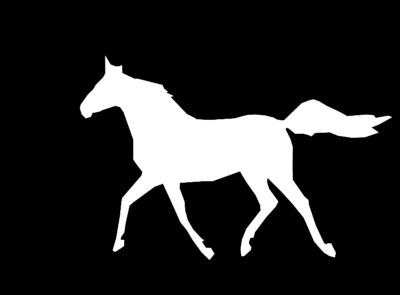

In [ ]:
path = '/content/drive/My Drive/horse_mask/'
masks = dict()
for filename in os.listdir(path):
  masks[filename] = cv2.imread(path + filename)
cv2_imshow(masks['horse001_mask.png'])

This is my hand-created ground truth (golden label).

In [ ]:
sift = cv2.SIFT_create()
all_descriptors = []
all_kps = []

def norm_descriptors(desc):
  norms = np.linalg.norm(desc, axis=1, keepdims=True)
  norms[norms == 0] = 1e-8
  return desc / norms



for gray in all_images:
  kp, des = sift.detectAndCompute(gray,None)
  all_kps.append(kp)
  des = norm_descriptors(des)
  all_descriptors.append(des)


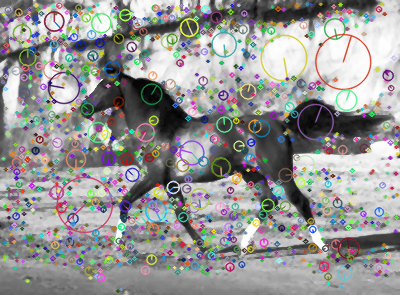

In [ ]:
img_with_keypoints = cv2.drawKeypoints(all_images[0], all_kps[0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2_imshow(img_with_keypoints)

I used SIFT for keypoint detection. The histogram equalization likely helped because the photo has many high-contrast areas, resulting in a significant number of keypoints. I suspected that using clustering algorithms might not be effective in identifying meaningful patterns. I normalized the descriptors.


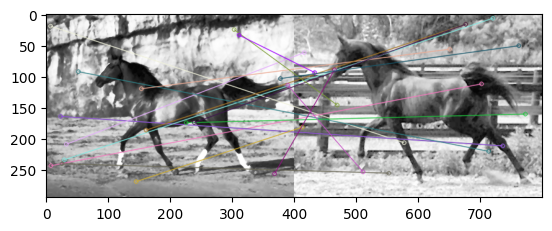

(<matplotlib.image.AxesImage at 0x7fc4d708cc10>, None)

In [ ]:
import matplotlib.pyplot as plt

bf = cv2.BFMatcher()

matches = bf.knnMatch(all_descriptors[0], all_descriptors[last], k=2)

alpha = 0.78

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < alpha*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(all_images[0],all_kps[0],
                         all_images[last],all_kps[last],good,None,
                         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

Having applied SIFT detection to all the images, I decided to compare the keypoints between two specific images to see if any meaningful relationships emerged. Unfortunately, I wasn't able to identify any patterns, even after trying different alpha values. Increasing the alpha value led to more keypoint matching, but these matches were occur in high-contrast areas and weren't meaningful.

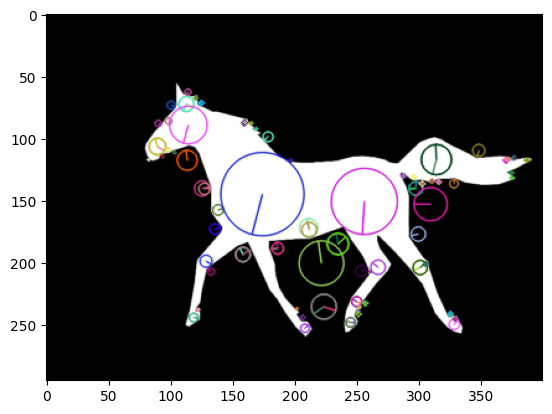

In [ ]:
all_descriptors_masks = []
kp_mask = None
horse_mask = masks['horse001_mask.png']
for mask in masks.values():
  kp_mask, des = sift.detectAndCompute(mask, None)
  des = norm_descriptors(des)
  all_descriptors_masks.append(des)

img_with_keypoints = cv2.drawKeypoints(
    horse_mask, kp_mask,
    None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img_with_keypoints)

I then decided to analyze the ground truth data, hoping it would somehow help me calculate the confusion matrix. As expected, the keypoints were concentrated on borders. Spoiler, this analysis didn't provide any insights for the confusion matrix.


In [ ]:
white_kp = []
black_kp = []
all_kp = len(kp_mask)
ground_truth = np.empty(all_kp, dtype=np.uint8) # 1 horse 0 background

for i,k in enumerate(kp_mask):
  if (horse_mask[int(k.pt[1]), int(k.pt[0])] != 0).all():
    white_kp.append(k)
    ground_truth[i] = 1
  else:
    black_kp.append(k)

white_des = all_descriptors_masks[0][np.where(ground_truth == 1)[0]]
black_des = all_descriptors_masks[0][np.where(ground_truth == 0)[0]]

print(f'Inside the house: {len(white_kp)} -- outside: {len(black_kp)}')


Inside the house: 44 -- outside: 58


Created a ground truth label for the mask by hand. If point has a white pixel, that is 1

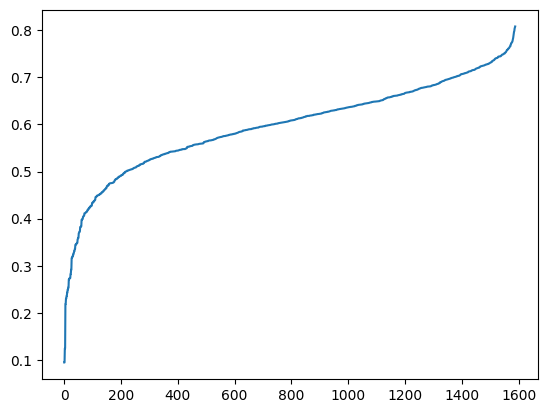

In [ ]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neighbors = NearestNeighbors(n_neighbors=156)
neighbors_fit = neighbors.fit(all_descriptors[0])
distances, indices = neighbors_fit.kneighbors(all_descriptors[0])
distances = np.sort(distances, axis =0)
distances = distances[:, 1]
plt.plot(distances)

In this step, I'm training to determine the optimal epsilon parameter for the DBSCAN clustering algorithm applied to the descriptors of the grayscale image. Why BDSCAN? Because, I hypothesized that the algorithm might identify patterns ('close' points) specific to this horse that could be useful for identification.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps = 0.46
min_samples = 4
all_labels = []
bad_split = 0
exce_split = 0
rest_splits = 0

clustering = DBSCAN(eps=eps, min_samples=min_samples)
for des in all_descriptors:
  np_d = np.array(des)
  kmeans = clustering.fit_predict(np_d)
  labels = clustering.labels_
  all_labels.append(labels)
  # try:
  s = silhouette_score(np_d, kmeans)
  # except ValueError:
  #   print("Probabily change the eps and min_samples values")
  if s > 0.7:
    exce_split += 1
  elif s < 0.25:
    bad_split += 1
  else:
    rest_splits += 1

print(f'Excellent splits: {exce_split}, Bad Splits: {bad_split}, The rest: {rest_splits}')

Excellent splits: 0, Bad Splits: 327, The rest: 0


During the clustering stage, the silhouette score indicated poor performance. To address this, I attempted dimensionality reduction on the descriptors. However, reducing the dimensions resulted in a significant loss of explained variance, hindering the results. Conversely,  the reduction in dimensionality  above that point yielded no improvement. Therefore, I decided to retain the original dimensionality of 128 for the descriptors."

1543 marked as noise,  46 marked as part of a cluster
Explained variation per first image: [0.10618   0.0716777]
Cumulative variance explained by 2 principal components: 17.79%


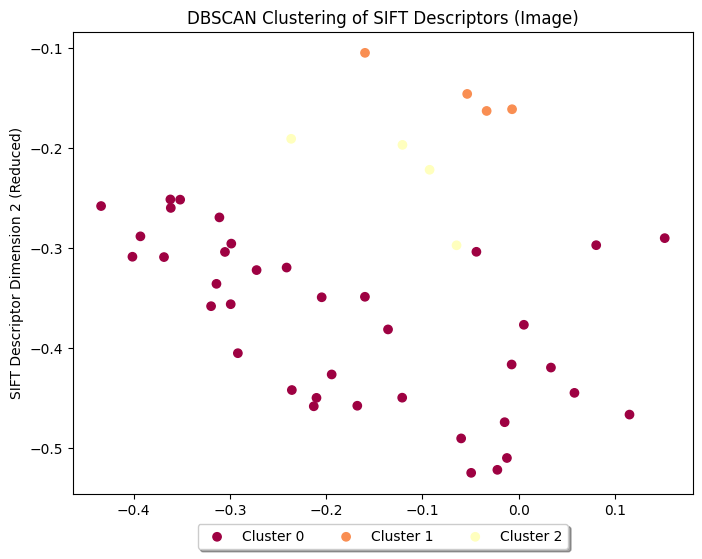

In [ ]:
from sklearn.decomposition import PCA
#plotting the cluster of the first image

noise_ = len(all_labels[0][all_labels[0] == -1])
print(noise_, "marked as noise, ", len(all_labels[0]) - noise_, "marked as part of a cluster")

plt.figure(figsize=(8, 6))
def plot_des(all_labels_img, ind=0, alg='DBSCAN', all_descriptors=all_descriptors, message=None):
  pca = PCA(n_components=2)
  reduced_des = pca.fit_transform(all_descriptors[ind])
  print('Explained variation per first image: {}'.format(pca.explained_variance_ratio_))
  print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))


  unique_lab_ = set(all_labels_img[ind])
  num_unique_val = len(unique_lab_)
  i = 0;
  scatters = list()
  for lab in unique_lab_:
    if lab == -1:
      continue
    labs_ = all_labels_img[ind]
    i += 1
    cluster_ind = np.where(labs_ == lab)[0]

    cl = plt.scatter(reduced_des[cluster_ind, 0], reduced_des[cluster_ind, 1],
                     c=[plt.cm.Spectral(float(i) /num_unique_val) for i in all_labels_img[ind][cluster_ind]])
    scatters.append(cl)

  plt.legend(tuple(scatters),
             tuple([f'Cluster {i}' for i in range(num_unique_val)]),
             scatterpoints=1,
             fontsize=10,
             loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
  plt.xlabel('SIFT Descriptor Dimension 1 (Reduced)')
  plt.ylabel('SIFT Descriptor Dimension 2 (Reduced)')
  plt.title(f'{alg} Clustering of SIFT Descriptors ({message})')
  plt.show()

plot_des(all_labels, 0, message='Image')

Surprisingly, even with a low minimum samples parameter, DBSCAN identified a large number of points as noise. This suggests that these points are too far apart in the feature space to be effectively clustered using DBSCAN. For the clustered points, I attempted to analyze their meaning by calculating a confusion matrix and projecting them on the image.


Cluster:0 Len: 38
Cluster:1 Len: 4   ------   Cluster:2 Len: 4   ------   

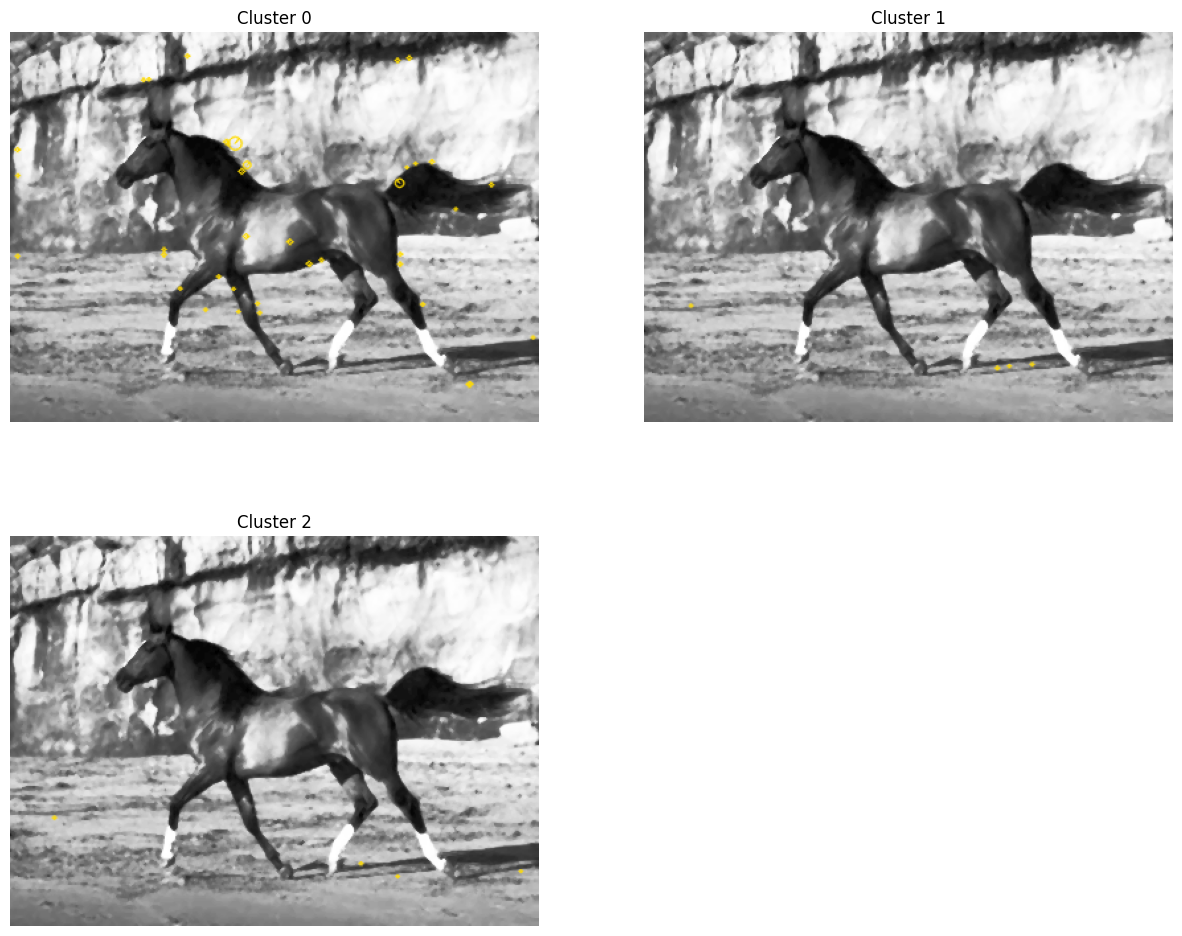

In [ ]:
import math

def plot_clust(first_labs, first_kp, image, labels_to_check, cols=2):
  first_kp = np.array(first_kp)
  first_labs = np.array(first_labs)
  fig = plt.figure(figsize=(10, 8))
  n_images = len(labels_to_check)

  for ind,lab in enumerate(labels_to_check):
    clust_i_ind = np.array(np.where(first_labs == lab)[0])
    all_i_cl = first_kp[clust_i_ind]
    end = '   ------   '
    if ind % 3 == 0:
      end = '\n'
    else:
      end = '   ------   '
    print(f'Cluster:{lab} Len: {len(all_i_cl)}', end = end)
    a = fig.add_subplot(cols, math.ceil(n_images/float(cols)), ind + 1)
    img_with_keypoints = cv2.drawKeypoints(
      image, all_i_cl,
      None, color=(255,219,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_keypoints)
    plt.axis('off')
    plt.title(f"Cluster {ind}")
  fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/2)
  plt.show()

ind_image_to_an = 0
found_cl = set(all_labels[ind_image_to_an])
found_cl.remove(-1)
plot_clust(all_labels[ind_image_to_an], all_kps[ind_image_to_an],
           all_images[ind_image_to_an], list(found_cl), cols=2)

Text(0.5, 1.0, 'Confusion Matrix of First Image with BDSCAN clustering')

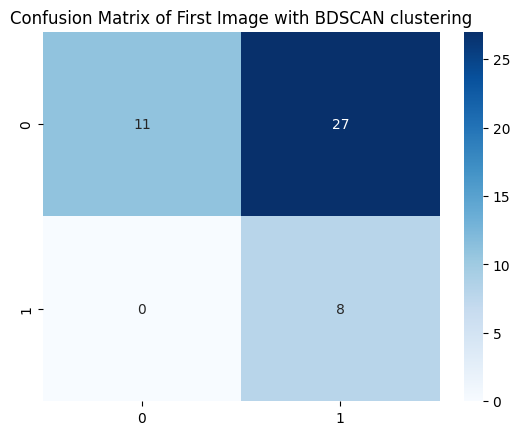

In [ ]:
import seaborn as sns

# We got 3 cluster, assume that the firsth should represent the horse,
# the rest are background
def check_col_pt(horse_mask, kps, ind_clusters, indx):
  indx_kp = ind_clusters[indx]
  kp = kps[indx_kp]
  return (horse_mask[round(kp.pt[1]), round(kp.pt[0])] != 0).all()

# cm[0,0] TP, cm[0,1] FP, cm[1, 0] FN, [1, 1] TN
def comp_cm(labels_horse, horse_cl, ind_horse, kps, horse_mask ):
  ind_clusters = np.where(labels_horse != -1)[0]
  labels_img = labels_horse[ind_clusters]
  cm = np.zeros([2,2], dtype=np.uint32)


  for indx,sl in enumerate(labels_img):
    if sl == horse_cl:

      if check_col_pt(horse_mask, kps, ind_clusters, indx): # if 0 background, else horse
        cm[0, 0] += 1
      else:
        cm[0, 1] += 1
    else:
      if check_col_pt(horse_mask, kps, ind_clusters, indx):
        cm[1, 0] += 1
      else:
        cm[1, 1] += 1
  return cm

horse_ind = 0
cm = comp_cm(all_labels[horse_ind], 0, horse_ind, all_kps[horse_ind], horse_mask)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.title("Confusion Matrix of First Image with BDSCAN clustering")


The recall is perfect (1.0) (but we lost myriad of points). All the horse points identified by the clustering algorithm belong to the same cluster. But, a bad precision of 0.28947368421.

Explained variation per first image: [0.15150402 0.12124987]
Cumulative variance explained by 2 principal components: 27.28%


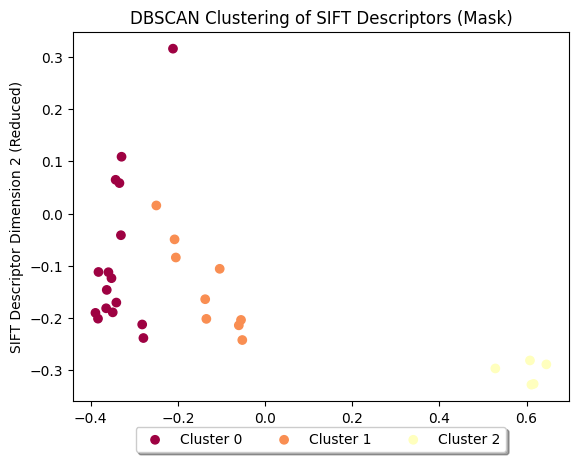

In [ ]:
all_labels_mask = []
for des in all_descriptors_masks:
  clustering.fit(des)
  all_labels_mask.append(clustering.labels_)

plot_des(all_labels_mask, ind=0, all_descriptors=all_descriptors_masks, message='Mask')

I applied the same process to the mask image.


Cluster:0 Len: 16
Cluster:1 Len: 9   ------   Cluster:2 Len: 5   ------   

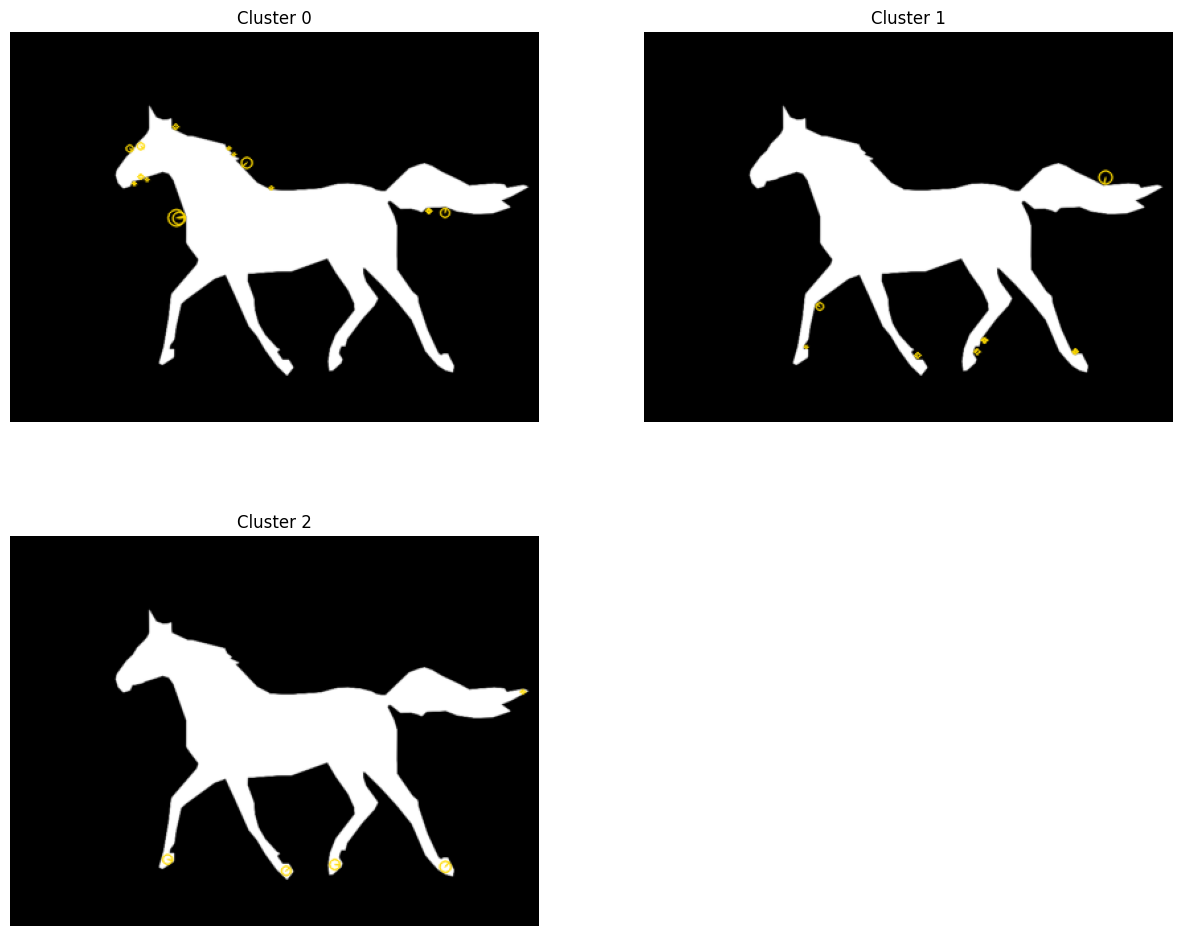

In [ ]:
found_cl = set(all_labels_mask[0])
found_cl.remove(-1)

plot_clust(all_labels_mask[0], kp_mask, horse_mask, found_cl)

Text(0.5, 1.0, 'Confusion Matxi of First Mask with BDSCAN clustering')

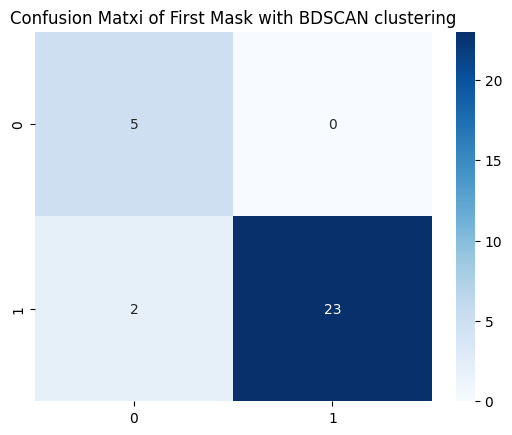

In [ ]:
horse_ind = 0
horse_cluster = 2 #suppose cluster 2 is the horse
cm = comp_cm(all_labels_mask[horse_ind], horse_cluster, horse_ind, kp_mask, horse_mask)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.title("Confusion Matxi of First Mask with BDSCAN clustering")

Precision is 1, It achieved a good recall of around 0.71.

In [ ]:
from enum import auto
from sklearn.cluster import KMeans

rest_splits = 0
exce_split = 0
bad_split =0
n_clusters = 2
kmeans = KMeans(n_clusters, random_state=0, n_init='auto')
all_kmean_labels = []
for des in all_descriptors:
  res = kmeans.fit_predict(des)
  all_kmean_labels.append(kmeans.labels_)
  s = silhouette_score(des, res)
  if s > 0.7:
    exce_split += 1
  elif s < 0.25:
    bad_split += 1

print(f'Excellent splits: {exce_split}, Bad Splits: {bad_split}, Rest split: {rest_splits}')



Excellent splits: 0, Bad Splits: 327, Rest split: 0


Given the poor performance of DBSCAN (as evidenced by the precision), I opted for the clustering algorithm you suggested

Explained variation per first image: [0.10618006 0.0716778 ]
Cumulative variance explained by 2 principal components: 17.79%


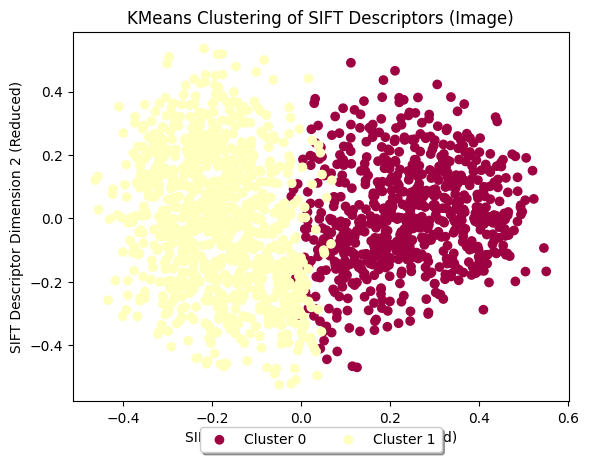

In [ ]:
plot_des(all_kmean_labels, ind=0, alg='KMeans', memssage='Image')


Cluster:0 Len: 692
Cluster:1 Len: 897   ------   

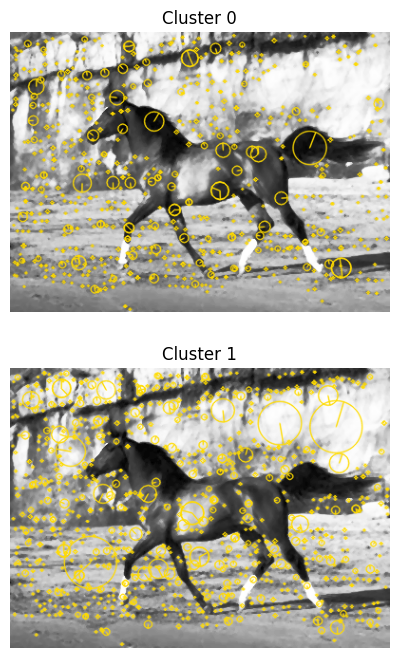

In [ ]:
plot_clust(all_kmean_labels[0], all_kps[0], all_images[0], [0, 1], cols=2)

In this case, the clustering algorithm wasn't able to identify any distinct groups that could reveal a meaningful pattern.

Text(0.5, 1.0, 'Confusion Matrix of First Image with KMean clustering')

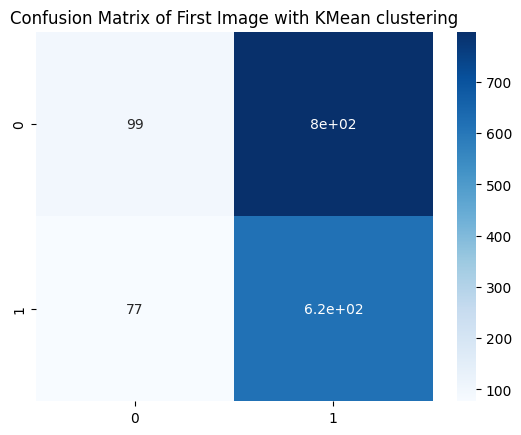

In [ ]:
#Suppose cluster 1 is the horse

horse_ind = 0
horse_cluster = 1 #suppose cluster 8 is the horse
cm = comp_cm(all_kmean_labels[horse_ind], horse_cluster, horse_ind, all_kps[0], horse_mask)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.title("Confusion Matrix of First Image with KMean clustering")

The recall is: 0.5625, which is not that bad. But, the precision is really bad of: 0.11012235817. Even if we consider cluster 0 to represent the horse, the overall results likely wouldn't change significantly.  Therefore, this approach seems ineffective for identifying foreground objects from the background.

Explained variation per first image: [0.15150402 0.12124987]
Cumulative variance explained by 2 principal components: 27.28%


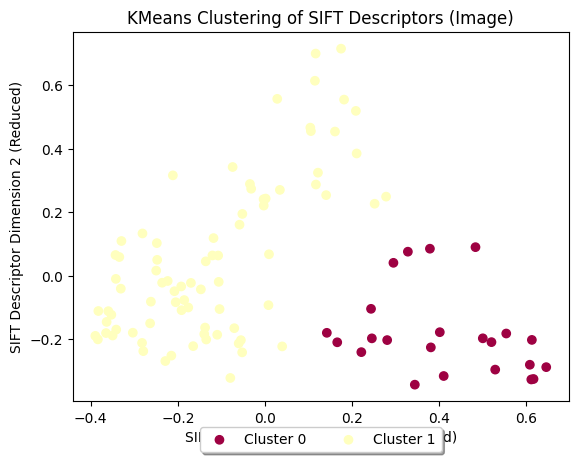

In [ ]:

all_kmean_labels_mask = []
for des in all_descriptors_masks:
  res = kmeans.fit_predict(des)
  all_kmean_labels_mask.append(kmeans.labels_)
  s = silhouette_score(des, res)
  if s > 0.7:
    exce_split += 1
  elif s < 0.25:
    bad_split += 1

plot_des(all_kmean_labels_mask, ind=0, all_descriptors=all_descriptors_masks, alg='KMeans', message='Image')



I clustered the mask

Cluster:0 Len: 23
Cluster:1 Len: 79   ------   

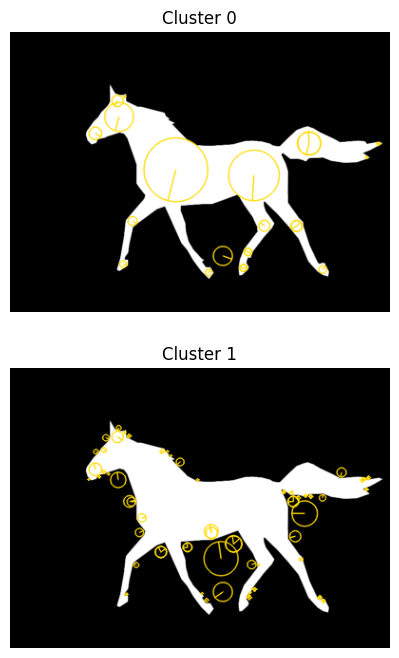

In [ ]:
plot_clust(all_kmean_labels_mask[0], kp_mask, horse_mask, [0, 1], cols=2)

Text(0.5, 1.0, 'Confusion First Mask BDSCAN clustering')

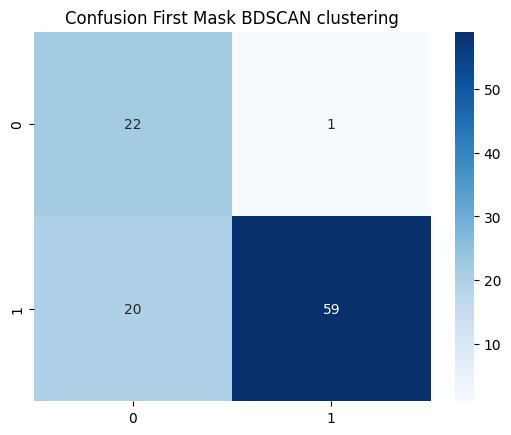

In [ ]:
horse_ind = 0
horse_cluster = 0 #suppose cluster 0 is the horse
cm = comp_cm(all_kmean_labels_mask[horse_ind], horse_cluster, horse_ind, kp_mask, horse_mask)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.title("Confusion First Mask BDSCAN clustering")

In this case the precision is really good of: 0.95652173913. But the recall is not that great of: 0.52380952381

**Considerations**


While SIFT excels at identifying objects that have undergone scaling or rotation, it's not the most suitable approach for image segmentation using clustering algorithms.  SIFT descriptors may not effectively capture the spatial relationships between objects that are crucial for scene description. These clusters, however, could potentially serve as a feature in a future Latent Dirichlet Allocation (LDA) model for image classification. One potential improvement could be to threshold more data points. This might allow us to identify the foreground object more effectively using a less descriptors.

A key limitation of clustering descriptors is their dependence on high-contrast areas. In our image, this abundance of high-contrast regions hinders the algorithm's ability to discriminate the object of interest. However, as I mentioned above, clustering can be a valuable first step for more advanced techniques.